In [1]:
import pandas as pd
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../../../data/high_category.csv")


In [2]:
def tokenize(text):
    return re.findall(r"\b\w+\b", str(text).lower())


SAMPLE_SIZES = [100, 200, 300, 500, 1000, 2000, 4000, 5000, 6000, 10000, 15000, 20000]
TOP_N = 100
TARGET_COLUMN = "aspect_summary"

print("\n🧠 MODEL OUTPUT STABILITY ANALYSIS BY PROGRESSIVE SAMPLE SIZE\n")
print(f"Analyzing top {TOP_N} words per growing dataset slice...\n")

results = []
prev_words = None
prev_freqs = None

for n in SAMPLE_SIZES:
    sample = df.iloc[:n]  # 👈 take first N rows instead of random sample

    # tokenize and count words
    words = [w for text in sample[TARGET_COLUMN] for w in tokenize(text)]
    freqs = Counter(words)
    top_words = dict(freqs.most_common(TOP_N))

    # compute metrics if previous sample exists
    if prev_words is not None:
        # --- 1) Overlap (Jaccard similarity) ---
        overlap = len(set(prev_words) & set(top_words)) / len(
            set(prev_words) | set(top_words)
        )

        # --- 2) Quantified frequency change ---
        common_words = set(prev_words) & set(top_words)
        changes = []
        for w in common_words:
            prev_count = prev_freqs[w]
            curr_count = top_words[w]
            rel_change = abs(curr_count - prev_count) / max(prev_count, 1)
            changes.append(rel_change)
        avg_change = np.mean(changes) if changes else 0

        results.append(
            {
                "sample_size": n,
                "word_overlap_%": round(overlap * 100, 2),
                "avg_freq_change_%": round(avg_change * 100, 2),
            }
        )

    prev_words = top_words
    prev_freqs = freqs

# === RESULTS OUTPUT ===
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

print("\n📘 INTERPRETATION:")
print("• Rows are taken sequentially (first N), not randomly.")
print("• 'word_overlap_%' shows how stable top vocabulary becomes as data grows.")
print("• 'avg_freq_change_%' measures variation in word frequencies across sizes.")
print(
    "• Expect overlap to increase and frequency changes to flatten as stability improves.\n"
)



🧠 MODEL OUTPUT STABILITY ANALYSIS BY PROGRESSIVE SAMPLE SIZE

Analyzing top 100 words per growing dataset slice...

 sample_size  word_overlap_%  avg_freq_change_%
         200           56.25              94.59
         300           63.93              51.34
         500           70.94              63.80
        1000           76.99             104.96
        2000           83.49             101.69
        4000           83.49              95.70
        5000           94.17              24.70
        6000           94.17              18.78
       10000           92.31              64.16
       15000           98.02              47.02
       20000           98.02              33.23

📘 INTERPRETATION:
• Rows are taken sequentially (first N), not randomly.
• 'word_overlap_%' shows how stable top vocabulary becomes as data grows.
• 'avg_freq_change_%' measures variation in word frequencies across sizes.
• Expect overlap to increase and frequency changes to flatten as stability improves.

In [3]:
df.groupby("high_category").size()

SAMPLE_SIZES_CATEGORY = [
    100,
    250,
    500,
    1000,
    2000,
    3000,
    4000,
    5000,
    6000,
    7000,
    8000,
    9000,
    10000,
    12000,
    13000,
]
TOP_N = 100
TARGET_COLUMN = "aspect_summary"

print("\n🧠 WORD STABILITY ANALYSIS BY HIGH_CATEGORY (Progressive Sample Sizes)\n")

all_results = []

# Loop through each high_category
for high_cat, df_high in df.groupby("high_category"):
    print(f"\n🔹 Analyzing High Category: {high_cat}")
    results = []
    prev_words = None
    prev_freqs = None

    for n in SAMPLE_SIZES_CATEGORY:
        # Only proceed if we have at least n rows in this category
        if len(df_high) < n:
            continue

        sample = df_high.iloc[:n]  # first N rows for this category

        # Tokenize and count words
        words = [w for text in sample[TARGET_COLUMN] for w in tokenize(text)]
        freqs = Counter(words)
        top_words = dict(freqs.most_common(TOP_N))

        # Compare with previous sample (if available)
        if prev_words is not None:
            # --- 1) Overlap (Jaccard similarity) ---
            overlap = len(set(prev_words) & set(top_words)) / len(
                set(prev_words) | set(top_words)
            )

            # --- 2) Frequency change ---
            common_words = set(prev_words) & set(top_words)
            changes = [
                abs(top_words[w] - prev_freqs[w]) / max(prev_freqs[w], 1)
                for w in common_words
            ]
            avg_change = np.mean(changes) if changes else 0

            results.append(
                {
                    "high_category": high_cat,
                    "sample_size": n,
                    "word_overlap_%": round(overlap * 100, 2),
                    "avg_freq_change_%": round(avg_change * 100, 2),
                }
            )

        prev_words = top_words
        prev_freqs = freqs

    # Save and print per-category table
    if results:
        df_results = pd.DataFrame(results)
        all_results.append(df_results)
        print(df_results.to_string(index=False))
    else:
        print("   ⚠️ Not enough samples for progressive analysis in this category.")

# Combine all into one final dataframe
final_df = pd.concat(all_results, ignore_index=True)

print("\n📊 SUMMARY: Average Stability by High Category\n")
summary = (
    final_df.groupby("high_category")[["word_overlap_%", "avg_freq_change_%"]]
    .mean()
    .round(2)
)
print(summary.to_string())

print("\n📘 INTERPRETATION:")
print("• Each table shows how top-word stability evolves for one category.")
print(
    "• The summary table averages overlap and frequency change across all sample sizes."
)
print(
    "• Categories with higher overlap% and lower freq_change% are more lexically stable."
)
print("• You can visually compare which high_categories stabilize faster.\n")



🧠 WORD STABILITY ANALYSIS BY HIGH_CATEGORY (Progressive Sample Sizes)


🔹 Analyzing High Category: GENERAL_FEEDBACK
   high_category  sample_size  word_overlap_%  avg_freq_change_%
GENERAL_FEEDBACK          250           52.67             153.47
GENERAL_FEEDBACK          500           69.49              91.71
GENERAL_FEEDBACK         1000           75.44             115.02
GENERAL_FEEDBACK         2000           83.49             100.23
GENERAL_FEEDBACK         3000           90.48              46.24
GENERAL_FEEDBACK         4000           90.48              31.94
GENERAL_FEEDBACK         5000           94.17              24.27
GENERAL_FEEDBACK         6000           96.08              19.26

🔹 Analyzing High Category: INFRASTRUCTURE
 high_category  sample_size  word_overlap_%  avg_freq_change_%
INFRASTRUCTURE          250           69.49             137.77
INFRASTRUCTURE          500           76.99             105.70
INFRASTRUCTURE         1000           85.19              94.12

🔹 

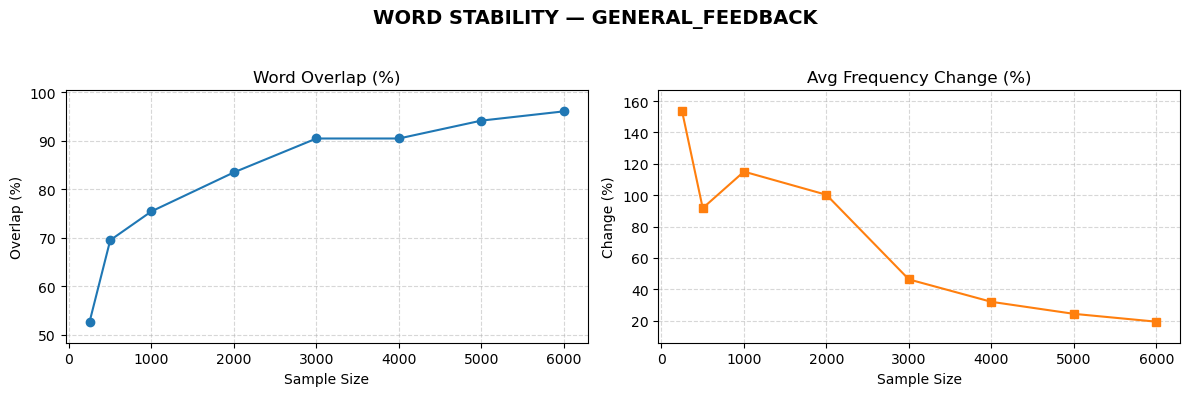

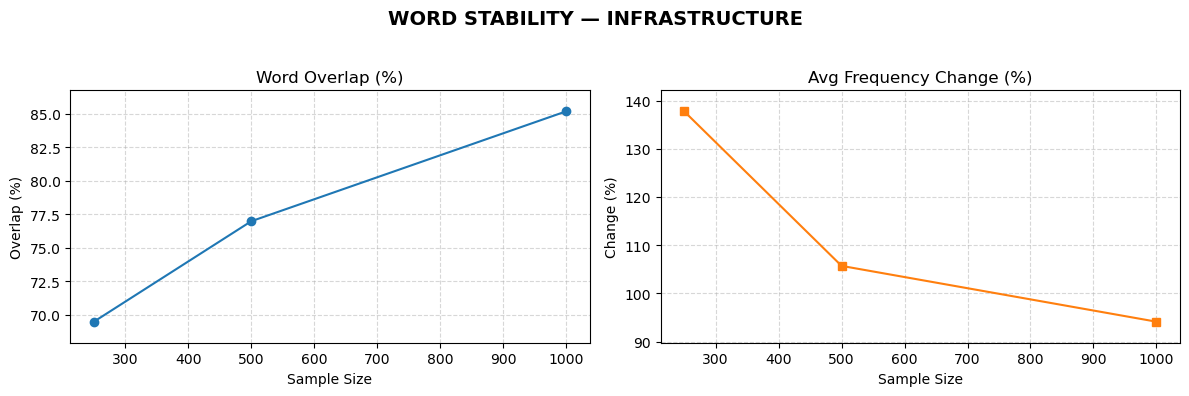

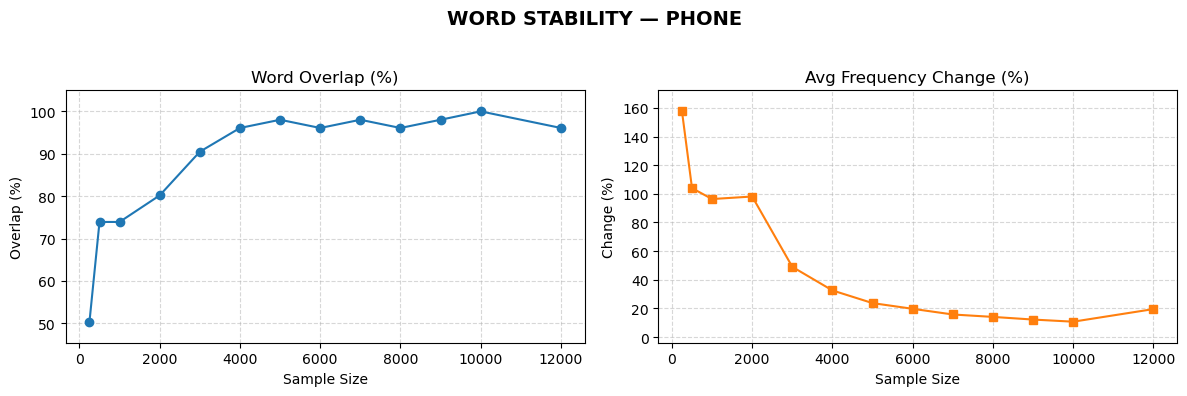

In [4]:

for high_cat, sub_df in final_df.groupby("high_category"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    fig.suptitle(f"WORD STABILITY — {high_cat}", fontsize=14, fontweight="bold")

    # === Compute dynamic y-limits ===
    overlap_min = sub_df["word_overlap_%"].min()
    overlap_max = sub_df["word_overlap_%"].max()
    freq_min = sub_df["avg_freq_change_%"].min()
    freq_max = sub_df["avg_freq_change_%"].max()

    # Add a little padding (optional)
    overlap_pad = (overlap_max - overlap_min) * 0.1
    freq_pad = (freq_max - freq_min) * 0.1

    # --- Left plot: Word Overlap ---
    axes[0].plot(
        sub_df["sample_size"], sub_df["word_overlap_%"], marker="o", color="tab:blue"
    )
    axes[0].set_title("Word Overlap (%)")
    axes[0].set_xlabel("Sample Size")
    axes[0].set_ylabel("Overlap (%)")
    axes[0].grid(True, linestyle="--", alpha=0.5)
    axes[0].set_ylim(overlap_min - overlap_pad, overlap_max + overlap_pad)

    # --- Right plot: Avg Freq Change ---
    axes[1].plot(
        sub_df["sample_size"],
        sub_df["avg_freq_change_%"],
        marker="s",
        color="tab:orange",
    )
    axes[1].set_title("Avg Frequency Change (%)")
    axes[1].set_xlabel("Sample Size")
    axes[1].set_ylabel("Change (%)")
    axes[1].grid(True, linestyle="--", alpha=0.5)
    axes[1].set_ylim(freq_min - freq_pad, freq_max + freq_pad)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


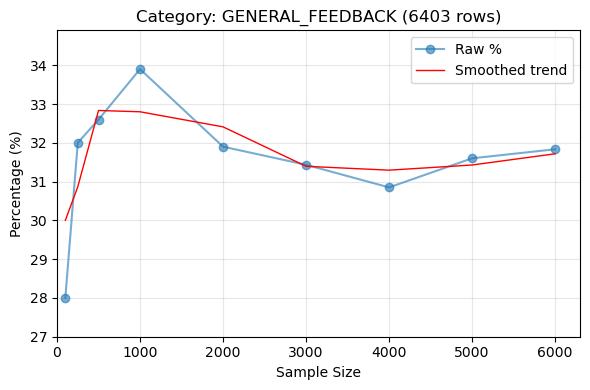

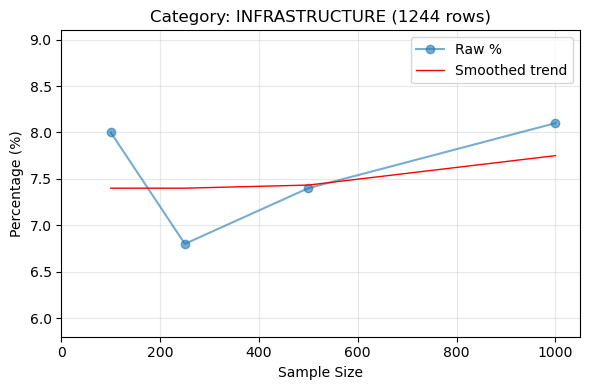

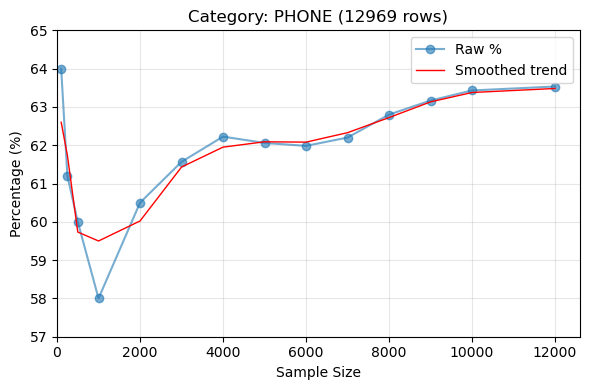

In [5]:
SAMPLE_SIZES_CATEGORY = [
    100,
    250,
    500,
    1000,
    2000,
    3000,
    4000,
    5000,
    6000,
    7000,
    8000,
    9000,
    10000,
    12000,
    13000,
]

# --- Compute percentage distributions per sample size ---
results = []

for n in SAMPLE_SIZES_CATEGORY:
    if len(df) < n:
        continue

    sample = df.iloc[:n]
    dist = sample["high_category"].value_counts(normalize=True) * 100
    temp = pd.DataFrame(
        {"sample_size": n, "category": dist.index, "percentage": dist.values}
    )
    results.append(temp)

df_results = pd.concat(results, ignore_index=True)

# --- Plot each category independently with smoothing ---
for cat, cat_df in df.groupby("high_category"):
    total_rows = len(cat_df)

    # Get only sample sizes up to category's data size
    valid_sizes = [n for n in SAMPLE_SIZES_CATEGORY if n <= total_rows]
    cat_results = df_results[
        (df_results["category"] == cat) & (df_results["sample_size"].isin(valid_sizes))
    ]

    if cat_results.empty:
        continue

    cat_results = cat_results.sort_values("sample_size")

    # Smooth trend using rolling mean (window=3, adjustable)
    smooth_y = (
        cat_results["percentage"].rolling(window=3, min_periods=1, center=True).mean()
    )

    plt.figure(figsize=(6, 4))
    plt.plot(
        cat_results["sample_size"],
        cat_results["percentage"],
        marker="o",
        label="Raw %",
        alpha=0.6,
    )
    plt.plot(
        cat_results["sample_size"],
        smooth_y,
        color="red",
        linewidth=1,
        label="Smoothed trend",
    )

    plt.title(f"Category: {cat} ({total_rows} rows)")
    plt.xlabel("Sample Size")
    plt.ylabel("Percentage (%)")

    # Independent axes
    plt.xlim(0, valid_sizes[-1] + valid_sizes[-1] * 0.05)
    ymin, ymax = cat_results["percentage"].min(), cat_results["percentage"].max()
    plt.ylim(max(0, ymin - 1), min(100, ymax + 1))

    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


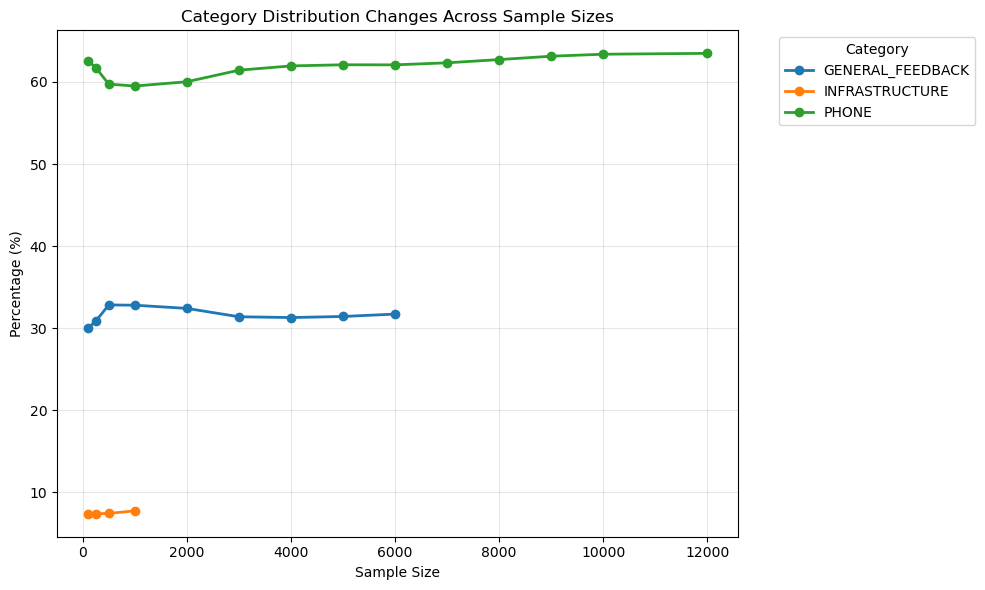

In [6]:
plt.figure(figsize=(10, 6))

for cat, cat_df in df.groupby("high_category"):
    total_rows = len(cat_df)

    # include only sample sizes within category size
    valid_sizes = [n for n in SAMPLE_SIZES_CATEGORY if n <= total_rows]
    cat_results = df_results[
        (df_results["category"] == cat) & (df_results["sample_size"].isin(valid_sizes))
    ]

    if cat_results.empty:
        continue

    cat_results = cat_results.sort_values("sample_size")

    # smoothing
    smooth_y = (
        cat_results["percentage"].rolling(window=3, min_periods=1, center=True).mean()
    )

    # plot line that naturally ends when data ends
    plt.plot(cat_results["sample_size"], smooth_y, marker="o", linewidth=2, label=cat)


plt.title("Category Distribution Changes Across Sample Sizes")
plt.xlabel("Sample Size")
plt.ylabel("Percentage (%)")
plt.grid(True, alpha=0.3)
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
